In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
pd.set_option('display.max_columns', None)
from shapely.geometry import Point
import fiona
import math
import plotly.express as px
from thefuzz import fuzz
from thefuzz import process

In [33]:
#Read in the data and keep only US Continental States and DC
stores_2022 = pd.read_csv('/srv/data/my_shared_data_folder/rafi/2022_Business_Academic_QCQ_grocery.csv')
stores_2022.drop(['Unnamed: 0'],inplace=True,axis=1)
territories = ['PR', 'FM', 'MP', 'GU', 'VI', 'MH']
stores_2022 = stores_2022.drop(stores_2022[stores_2022['STATE'].isin(territories)].index)

In [34]:
#Create lists of Supermarkets/Companies owned by the Parent Coporations of Interest (Supermarkets/Companies were taken from Wikipedia)

#Ahold Delhaize owned supermarkets/companies
ahold = ["Bottom Dollar Food",
    "Food Lion",
    "FreshDirect",
    "Giant",
    "Giant Food",
    "Hannaford",
    "Stop & Shop",
    "Peapod",
    "Bfresh",
    "Eastside Marketplace",]

#WALMART owned supermarkets/companies
walmart = ["WALMART","SAM'S CLUB"]

#Krogers owned supermarkets/companies
kroger = ["Baker's",
    "City Market",
    "Dillons",
    "Food 4 Less",
    "Foods Co.",
    "Fred Meyer",
    "Fry's",
    "Gerbes",
    "Harris Teeter",
    "JayC",
    "King Soopers",
    "Kroger",
    "Mariano's",
    "Metro Market",
    "Pay Less",
    "Pick 'n Save",
    "QFC",
    "Ralphs",
    "Ruler Foods",
    "Smith's",]

# Albertsons owned supermarkets/companies
albertsons= ["Acme Markets",
    "Albertsons",
    "Albertsons Market",
    "Amigos",
    "Andronico's",
    "Balducci's",
    "Carrs",
    "Haggen",
    "Jewel-Osco",
    "Kings Food Markets",
    "Lucky",
    "Market Street",
    "Pak 'n Save",
    "Pavilions",
    "Randalls",
    "Safewa",
    "Shaw's",
    "Star Market",
    "Tom Thumb",
    "United Supermarkets",
    "Vons",
    "Buttrey Food and Drug",
    "Max Food and Drug",
    "Max Foods",
    "Skagg's Albertsons",
    "Super Saver",]

#Costco owned supermarkets/companies
costco = ["Costco"]

In [35]:
#Apply a string match through thefuzz that compares all stores to the parent corporations owned stores
#We decided to use a threshold of 77
#Generates a list of potential unique string matches
#The matches list's length is based on the number of different stores the parent corporation owns
#parent was initialized for each parent coporation (finished at costco)
'''
parent = costco
companies = stores_2022["COMPANY"]

matches = []
for item in parent:
    for result in process.extract(item, companies, limit=len(parent)+1):
        store = result[0]
        score = result[1]
        if score >= 77 and store not in matches:
            matches.append(store)

print(matches)

# i.e. returns: ['COSTCO DELI']
'''

'\nparent = costco\ncompanies = stores_2022["COMPANY"]\n\nmatches = []\nfor item in parent:\n    for result in process.extract(item, companies, limit=len(parent)+1):\n        store = result[0]\n        score = result[1]\n        if score >= 77 and store not in matches:\n            matches.append(store)\n\nprint(matches)\n\n# i.e. returns: [\'COSTCO DELI\']\n'

In [36]:
#Generated String Matches from above

#String matched brands owned by Walmart:
walmart_string = ['WALMART GROCERY PICKUP', 'WALMART GROCERY PKUP-DELIVERY', "SAM'S CLUB DELI"]
#Doesn't appear to have Walmart Neighborhood Stores

#String matched brands owned by Ahold Delhaize:
ahold_string = ['BOTTOM DOLLAR', 'DOLLAR DOLLAR', 'FOOD', 'FOOD 4 LESS', 'FOOD LION', 'FRESH DIRECT', 'REC', 'FRESH', 'H & H', 'S & S', 'FRESHII', 'GIANT', 'GIANT EAGLE', 'GIANT EAGLE FLORAL', 'GIANT FOOD', 'HANNAFORD', 'STOP & SHOP', 'PEA POD', 'BFRESH MARKET', 'REFRESH', 'EASTSIDE MARKETPLACE', 'WESTSIDE MARKETPLACE', 'MARKET', 'E MARKET', 'MARKETPLACE']

#String matched brands owned by Kroger:
kroger_string = ["BAKER'S", 'S & S', 'BAKERS', "BAKER'S GAS & WELD SUPLS INC", "BAKER'S GAS", "BAKER'S MARKET", "BAKER'S PRO FARM LLC", 'BAKER STREET MARKET', "BAKER'S KWIK SHOP", 'CITY MARKET', 'DILLONS', 'FOOD 4 LESS', 'FOODS CO', 'FRED MEYER', "FRY'S FOOD", 'GERBES SUPER MARKET', 'GERBES SUPER MARKETS', 'GE', 'GERBES SUPERMARKET', 'HARRIS TEETER', 'JAYC', "JAYCEE'S", 'JAYCON', 'CITY-RALEIGH-JAYCEE PARK-CMNTY', 'JAYCE MINIMARKET', 'NAY & JAY', 'KING SOOPERS', 'KROGER', "MARIANO'S", 'METRO MARKET', 'METRO MINI MARKET', 'MARKET MARKET', 'PAY LESS LIQUORS', 'PAY LESS SUPER MARKETS', 'PAY LESS GAS & FOOD', 'PAY LESS IGA', 'FOOD FOR LESS', 'FAR LESS FOOD MARKET', 'MORE FOR LESS', 'PRICE LESS FOODS', 'COST LESS FOODS CO', "PICK'N SAVE", 'QFC', 'RALPHS', 'RULER FOODS', "SMITH'S"]

#String matched brands owned by Costco
costco_string = ["COSTCO DELI"]

#String matched brands owned by Albertsons
albertsons_string = ['ACME MARKETS', 'ALBERTSONS', 'ALBERTSONS MARKET', 'MARKET MARKET', 'MARKET', '2 AMIGOS', 'AMIGO', 'LOS AMIGOS DISTRIBUTING', 'DOS AMIGOS MARKET', '3 AMIGOS BEER WINE-FOOD STORE', 'THREE AMIGOS', 'AMIGOS FOOD MART', 'LOS AMIGOS', 'AMIGOS MKT LOS', 'AMIGOS MARKET 7', 'TIENDA LOS AMIGOS', 'AMIGOS CONVENIENCE STORE', 'LOS AMIGOS UNO', 'AMIGOS LATIN GROCERY', 'AMIGOS UNITED', 'AMIGOS FOOD MART LLC', 'LOS AMIGOS MARKET', 'LOS AMIGOS SUPERMARKET', 'ICO', "ANDRONICO'S COMMUNITY MARKETS", "KRAUSZER'S FOOD STORE", "CASEY'S", "MR T'S", "SEVEN'S", "PATTY'S PANTRY & DELI", "CASHION'S QUIK STOP", 'E C F S SNACKS LLC', "MICKEY'S T-MART INC", "STATLER'S COUNTRY MART", "MIKE'S CONVENIENCE", "BELL'S ROWLESBURG GROCERY", "SOCCORSI'S GROCERY & SUBS", 'CC', "BALDUCCI'S FOOD LOVER'S MARKET", "DANIEL'S MARKET", "GRILLO'S MARKET", 'S & G CONVENIENCE MART', "NANCY'S FOODMART", "MILLER'S MARKETS", "MAYNARD'S OF FLANDREAU", "SKIP'S", "HARDESTY'S EXPRESS MART LLC", "KASSAR'S FOOD & GIFTS", "JERRY'S MARKET & LIQUOR", "SHELLY'S GROCERY & BAKERY LLC", 'CARRS/SAFEWAY', 'CARRS SAFEWAY', 'CARRS QUALITY CTR PALMER SHPG', 'BIG CHEAP CASH & CARR', 'C & B USED CARS', 'HAGGEN', 'HAGGEN FOOD & PHARMACY', 'HAGGEN SUPPORT CTR', 'HAGGEN FOOD', 'GE', 'JEWEL-OSCO', 'KINGS FOOD MARKETS', 'KINGS FOOD MARKET', "KING'S FOOD MARKET", "KING'S FOODMARKET", 'KINGS FOOD MART', 'FOOD', 'LUCKY', 'LUCKY 3', 'LUCKY 7', "LUCKY'S", 'LUCKY 8', 'LUCKYS', 'LUCKY SEVEN FOOD STORE', 'LUCKY FOOD FARMERS MARKET', 'LUCKY GROCERY & DELI', 'LUCKY DOLLAR', 'LUCKY CHARM CONVENIENCE STORE', 'LUCKY STAR MARKET LLC', 'LUCKY FOOD MART LLC', 'LUCKY MARKET', "LUCKY'S STATION", 'LUCKY MARKET LLC', "LUCKY'S SUPER MARKET", 'MARKET STREET', "PAK 'N SAVE", 'U-SAVE FOOD STORE', 'GOLD LINE GRAB N GO', 'INDO PAK SUPERMARKET', 'STOP N GO FOOD MART', 'STOP N GO ENTERPRISES INC', "OCALA SHOP N' PLAY LLC", 'J & N MINI MART 2', "GRAB 'N GO MART LLC", 'KWIK PAK FOOD MART', "SHOP 'N SAVE EXPRESS", 'PIC-N-SAVE MARKET', 'U-SAVE TRAVEL PLAZA', "UP NORT' SWEET N SAVORY", 'STOP N SHOP WESTFIELD', "SACK 'N SAVE FOOD", "STOP 'N GO MARKETS OF TEXAS", 'CARTA N SHORE GARAGE', 'MASALA INDO PAK GROCERS', 'IN N OUT FOOD & GAS LLC', "GAS 'N' GO FOOD & BEVERAGE", 'N A M C COMMUNITY MARKET INC', 'PAVILIONS', 'RANDALLS', 'SAFEWAY', 'S & S', "SHAW'S SUPERMARKET", "SHAW'S SUPERMARKETS INC", 'STAR MARKET', 'TOM THUMB', 'UNITED SUPERMARKETS', 'VONS', 'FOOD 4 LESS', 'FOOD MART', 'FOOD LION', 'HERA FOOD MART', 'FOOD TOWN', 'FOOD FAIR', 'OHM FOOD MART', "D'S FOOD STORE", 'FOOD EXPRESS', 'E Z FOOD MART', 'JR FOOD MART', 'EXPRESS FOOD', 'MR FOOD MART', 'CITGO CONVENIENT FOOD MART', 'GREEN ACRES HEALTH FOOD STORE', 'FRIENDSHIP FOOD STORES INC', 'VERISTAS AFRICAN FOOD STORE', 'ILLINOIS VALLEY FOOD & DELI', "FRY'S FOOD", 'FOOD CITY', 'MAX FOODS', 'MAXI FOODS', 'FOODS', 'FOOD MAX', 'SUPER ONE FOODS', 'SUNSHINE FOODS', 'JAMBOREE FOODS', 'DAY STAR FOODS', "SULLIVAN'S FOODS", 'AFFILIATED FOODS CO-OP', "JENSEN'S FINEST FOODS", 'EAST DAKOTAH NATURAL FOODS', "JENSEN'S FOODS", 'RITE PRICE FOODS', 'VALLEY CENTER FOODS', 'SUPER SAVER', 'SUPER SAVE', 'SUPER SAVER INC', 'SUPER', 'SUPER SAVER COST PLUS', "SAAR'S SUPER SAVER FOODS"]

In [37]:
#Cleaned lists from the string matches of supermarkets/companies actually owned by the parent coprporation
#***NOTE***There will be a margin of error from this process because stores were validated through manual checks
#***NOTE***It was unrealistic to manually inspect every store generated this way so there will be supermarkets/companies that do not actually belong to the parent coporation
#***NOTE***STOP AND SHOP SUPERMARKET was missing from string match so it was manually added
#KROGERS FINAL
kroger_clean = ["BAKER'S",
 'BAKERS', 
 'CITY MARKET',
 'DILLONS',
 'FOOD 4 LESS', 
 'FOODS CO', 
 'FRED MEYER', 
 "FRY'S FOOD",
 'GERBES SUPER MARKET',  
 'GERBES SUPER MARKETS', 
 'GERBES SUPERMARKET', 
 'HARRIS TEETER', 
 'JAYC', 
 'KING SOOPERS',
 'KROGER',
 "MARIANO'S",
 'METRO MARKET', 
 'PAY LESS SUPER MARKETS',
 "PICK'N SAVE", 
 'QFC', 
 'RALPHS', 
 'RULER FOODS', 
 "SMITH'S"]

#Ahold Delhaize FINAL:
ahold_clean = [ 'FOOD LION',
 'GIANT',
 'GIANT EAGLE',
 'GIANT FOOD',
 'HANNAFORD',
 'STOP & SHOP',
 'BFRESH MARKET',
 'EASTSIDE MARKETPLACE','STOP & SHOP SUPERMARKET']

#WALMART FINAL:
walmart_clean = ['WALMART GROCERY PICKUP',
 'WALMART GROCERY PKUP-DELIVERY', 
 "SAM'S CLUB DELI"]

#COSTCO FINAL:
costco_clean = ["COSTCO DELI"]

#ALBERTSONS FINAL:
albertsons_clean = ['ACME MARKETS',
'ALBERTSONS',
'ALBERTSONS MARKET',
'AMIGOS UNITED',
"ANDRONICO'S COMMUNITY MARKETS",
'CARRS/SAFEWAY',
'CARRS SAFEWAY',
'HAGGEN',
'HAGGEN FOOD & PHARMACY',
'HAGGEN FOOD',
'JEWEL-OSCO',
'KINGS FOOD MARKETS',
'KINGS FOOD MARKET',
'MARKET STREET',
"PAK 'N SAVE",
'PAVILIONS',
'RANDALLS',
'SAFEWAY',
'STAR MARKET',
'TOM THUMB',
'UNITED SUPERMARKETS',
'VONS',
'SUPER SAVER',
'CARRS QUALITY CTR PALMER SHPG',
 "SAAR'S SUPER SAVER FOODS"]

In [38]:
#Records the removed values from the string matching for each store
#"Removed" list can be used to see the values we chose to remove from the string match
kroger_removed = [value for value in kroger_string if value not in kroger_clean]
ahold_removed = [value for value in ahold_string if value not in ahold_clean]
walmart_removed = [value for value in walmart_string if value not in walmart_clean]
costco_removed = [value for value in costco_string if value not in costco_clean]
albertsons_removed = [value for value in albertsons_string if value not in albertsons_string]

In [39]:
def parent_name(row):
    '''Creates a new column called "PARENT NAME" based on the cleaned string match list''' 
    '''The new column generalizes individual companies into their parent coporation (ie. Walmart, Krogers, etc.)''' 
    companies = row['COMPANY']  
    
    if companies in walmart_clean:
        return 'WALMART'
    if companies in costco_clean:
        return 'COSTCO'
    if companies in ahold_clean:
        return 'AHOLD DELHAIZE'
    if companies in kroger_clean:
        return 'KROGER'
    if companies in albertsons_clean:
        return 'ALBERTSONS'
    else:
        return 'OTHER'

stores_2022['PARENT NAME'] = stores_2022.apply(parent_name, axis=1)

In [40]:
#Locate the unique primary sic codes present within the supermarkets/companies owned by the parent corporations of interest
#These unique primary SIC codes will be used as the basis of how we filter the main dataset to include only relevant supermarkets/companies (ie. removing convenient stores)

#Step 1: Filter a dataframe based on parent coporations
parent_companies = ['WALMART', 'COSTCO', 'KROGER', 'AHOLD DELHAIZE','ALBERTSONS']
filtered_df = stores_2022[stores_2022['PARENT NAME'].isin(parent_companies)]

# Step 2: Extract the PRIMARY SIC CODES values
primary_sic_codes = filtered_df['PRIMARY SIC CODE']

# Step 3: Get the unique PRIMARY SIC CODES values
unique_sic_codes = primary_sic_codes.unique()

# Print the unique PRIMARY SIC CODES
unique_sic_codes = np.delete(unique_sic_codes,(np.where(unique_sic_codes == 541103)))

#***NOTE remove SIC Code 541103 since it contains the SIC code for convenient stores

In [41]:
def sic_filter(df):
    """
    Filters the dataframe to keep only the stores with specific primary SIC codes,
    including NaN values. SIC codes are from the parent corporation's subsidiary's Primary SIC codes

    The function takes in an unfiltered dataframe as a parameter.
    The function returns a filtered dataframe.
    """
    sic_codes = unique_sic_codes
    filtered_df = df[df['PRIMARY SIC CODE'].isin(sic_codes) | df['PRIMARY SIC CODE'].isna()]
    return filtered_df

supermarkets_2022 = sic_filter(stores_2022)

In [42]:
def update_parent_name(df):
    """
    Helps account for erros in manual string matching selection
    Checked for different Parent Numbers within each Parent Group and if the company had a different Parent Number 
    than the accepted, the company was grouped to other
    """
    accepted_parent_numbers = {
        238136725.0: "AHOLD DELHAIZE",
        5995907.0: "ALBERTSONS",
        7521503.0: "KROGER",
        5889993.0: "WALMART",
        441311800.0: "COSTCO"
    }
    
    for parent_number, parent_name in accepted_parent_numbers.items():
        df.loc[(df["PARENT NUMBER"] != parent_number) & (df["PARENT NAME"] == parent_name), "PARENT NAME"] = "OTHER"
    
    return df
supermarkets_2022 = update_parent_name(supermarkets_2022)
#Assigns Parent Number of Albertsons to CARRS
supermarkets_2022.loc[supermarkets_2022[supermarkets_2022["COMPANY"] == "CARRS QUALITY CTR PALMER SHPG"].index, "PARENT NUMBER"] = 5995907.0

In [43]:
supermarkets_2022.shape
#There are 78449 supermarkets/related companies in the entire US

(78449, 54)

In [44]:
#Finds the Percent of Brick and Mortar and Store Count for Each Major Parent Company and Other
store_count_us = supermarkets_2022.groupby('PARENT NAME').count()[["CITY"]].reset_index().rename(columns={"CITY":"STORE COUNT"})
store_count_us['Percent'] = store_count_us['STORE COUNT'] / supermarkets_2022.shape[0] * 100

store_count_us

,PARENT NAME,STORE COUNT,Percent
0,AHOLD DELHAIZE,1713,2.183584
1,ALBERTSONS,2191,2.792897
2,COSTCO,29,0.036967
3,KROGER,2716,3.462122
4,OTHER,68098,86.805440
5,WALMART,3702,4.718989


# Illinois Analysis

In [45]:
supermarkets_2022_il = supermarkets_2022.loc[supermarkets_2022["STATE"] == "IL"]
supermarkets_2022_il.head() 
#There are 2662 Supermarkets/companies in IL

,COMPANY,ADDRESS LINE 1,CITY,STATE,ZIPCODE,ZIP4,COUNTY CODE,AREA CODE,IDCODE,LOCATION EMPLOYEE SIZE CODE,LOCATION SALES VOLUME CODE,PRIMARY SIC CODE,SIC6_DESCRIPTIONS,PRIMARY NAICS CODE,NAICS8 DESCRIPTIONS,SIC CODE,SIC6_DESCRIPTIONS (SIC),SIC CODE 1,SIC6_DESCRIPTIONS (SIC1),SIC CODE 2,SIC6_DESCRIPTIONS(SIC2),SIC CODE 3,SIC6_DESCRIPTIONS(SIC3),SIC CODE 4,SIC6_DESCRIPTIONS(SIC4),ARCHIVE VERSION YEAR,YELLOW PAGE CODE,EMPLOYEE SIZE (5) - LOCATION,SALES VOLUME (9) - LOCATION,BUSINESS STATUS CODE,INDUSTRY SPECIFIC FIRST BYTE,YEAR ESTABLISHED,OFFICE SIZE CODE,COMPANY HOLDING STATUS,ABI,SUBSIDIARY NUMBER,PARENT NUMBER,PARENT ACTUAL EMPLOYEE SIZE,PARENT ACTUAL SALES VOLUME,PARENT EMPLOYEE SIZE CODE,PARENT SALES VOLUME CODE,SITE NUMBER,ADDRESS TYPE INDICATOR,POPULATION CODE,CENSUS TRACT,CENSUS BLOCK,LATITUDE,LONGITUDE,MATCH CODE,CBSA CODE,CBSA LEVEL,CSA CODE,FIPS CODE,PARENT NAME
13,KROGER,301 E MCKINLEY RD,OTTAWA,IL,61350,4805.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,70.0,14158.0,2,P,NaN,NaN,NaN,152123287,NaN,7521503.0,1200.0,137888000.0,I,I,152123287.0,NaN,7,963500.0,1.0,41.323858,-88.836271,P,36837.0,1.0,176.0,17099.0,KROGER
199,SPRING VALLEY SUPERMARKET,117 S SPALDING ST,SPRING VALLEY,IL,61362,2097.0,11.0,815,2,E,E,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,542107.0,MEAT-RETAIL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,60.0,8908.0,9,NaN,NaN,NaN,NaN,2994101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,965200.0,2.0,41.323951,-89.199282,P,36837.0,1.0,176.0,17011.0,OTHER
316,SENECA FOOD MART,271 S MAIN ST,SENECA,IL,61360,9415.0,99.0,815,2,B,C,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,209903.0,FOOD PRODUCTS & MANUFACTURERS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,8.0,1618.0,2,NaN,NaN,NaN,NaN,152142808,NaN,558247.0,75.0,1385280.0,E,K,NaN,NaN,4,963700.0,1.0,41.306622,-88.610207,P,36837.0,1.0,176.0,17099.0,OTHER
379,HANDY FOODS,604 W MAIN ST,OTTAWA,IL,61350,2718.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,90.0,19214.0,9,L,1963.0,NaN,NaN,152124368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,962800.0,4.0,41.346474,-88.848812,P,36837.0,1.0,176.0,17099.0,OTHER
435,SULLIVAN'S FOODS,1102 MERIDEN ST,MENDOTA,IL,61342,1054.0,99.0,815,2,E,F,541105,GROCERS-RETAIL,44511003.0,SUPERMARKETS/OTHER GROCERY (EXC CONVENIENCE) STRS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022,39106.0,72.0,14562.0,2,NaN,1967.0,NaN,NaN,2971463,NaN,356801134.0,NaN,389500.0,NaN,I,2971463.0,NaN,5,961900.0,3.0,41.555409,-89.125462,0,36837.0,1.0,176.0,17099.0,OTHER


In [46]:
#Finds the Percent of Brick and Mortar and Store Count for Each Major Parent Company and Other in IL
store_count_il = supermarkets_2022_il.groupby('PARENT NAME').count()[["CITY"]].reset_index().rename(columns={"CITY":"STORE COUNT"})
store_count_il['Percent'] = store_count_il['STORE COUNT'] / supermarkets_2022_il.shape[0] * 100

store_count_il

#External Sources
#ALBERTSONS: 188 Locations (Jewel-Osco) (wikipedia)
#KROGER: 88 Total: "31 grocery stores across 25 cities in Illinois" (Kroger.com) + 44 Mariano's (Mariano's.com) + 13 Ruler Foods (google maps)
#WALMART: 169 Total Retail Units not including discount stores (Supercenters; Neighborhood Markets; Sam's Club) (Walmart.com)
#COSTCO: 23 Warehouses (Costco.com)
#AHOLD DELHAIZE: 0 (wikipedia)

,PARENT NAME,STORE COUNT,Percent
0,ALBERTSONS,188,7.062359
1,KROGER,100,3.756574
2,OTHER,2247,84.410218
3,WALMART,127,4.770849


# Market Share

In [47]:
#to do: map groceries in country; map of metro area

In [48]:
#Market Share = (Bussines Rev/Total Industry Rev) x 100

In [49]:
#If a store under the Parent Name Other had no PARENT ACTUAL SALES VOLUME recorded then we summed the total sales at each of that specific store's location and subsituted it in
#FIND THE TOTAL SALES for the OTHER category
other_sales = supermarkets_2022.loc[supermarkets_2022.loc[:, "PARENT NAME"]=="OTHER", ["PARENT NUMBER", "PARENT ACTUAL EMPLOYEE SIZE", "PARENT ACTUAL SALES VOLUME", "SALES VOLUME (9) - LOCATION"]]
other_sales.loc[(other_sales.loc[:,"PARENT ACTUAL SALES VOLUME"].isna()),"PARENT ACTUAL SALES VOLUME"] = other_sales.loc[(other_sales.loc[:,"PARENT ACTUAL SALES VOLUME"].isna()),"SALES VOLUME (9) - LOCATION"] * 1000
other_sales = other_sales.drop_duplicates()
other_sales = other_sales.rename(columns={"PARENT ACTUAL SALES VOLUME":"OTHER TOTAL SALES"})

other_sales_volume = other_sales["OTHER TOTAL SALES"].sum()

print("OTHER TOTAL SALES:", other_sales_volume)

OTHER TOTAL SALES: 641535248290.0


***NOTE Because the data is inconsistent and PARENT ACTUAL SALES do not corroborate with Fiscal Reports issued by Parent Companies we will be using actual net sales data provided by parent company annual reports; not the PARENT ACTUAL SALES VOLUME column***
COSTCO: 85.6 Billion Food and Sundries (statista.com)
WALMART: 218.944 Billion Groceries (walmart 2023 annual report)
ALBERTSONS: 77.6497 Billion (ALBERTSONS 2023 annual report)
KROGER: 148.3 Billion (Kroger)
AHOLD DELHAIZE: .060464538 (in Billions) (AHOLD DElHAIZE) (US)

Limitations: Albertsons Fiscal Report does not distinguish grocery stores and gas stations; Kroger owns 2 non-supermarket companies

supermarkets_2022 PARENT ACTUAL SALES:
COSTCO: 5098266.0
WALMART: 572754000.0
ALBERTSONS: NAN
KROGER: 137888000.0
AHOLD DELHAIZE: 44000000.0

In [50]:
def true_sales(row):
    '''Creates a new column called "PARENT NAME" based on the cleaned string match list''' 
    '''The new column generalizes individual companies into their parent coporation (ie. Walmart, Krogers, etc.)''' 
    companies = row['PARENT NAME']  
    
    if companies == "WALMART":
        return 218.944
    if companies == "COSTCO":
        return 85.6
    if companies == "ALBERTSONS":
        return 77.6497
    if companies == "KROGER":
        return 148.3
    if companies == "AHOLD DELHAIZE":
        return .060464538
    if companies == "OTHER":
        return 641.535248

supermarkets_2022['PARENT TRUE SALES (BILLIONS)'] = supermarkets_2022.apply(true_sales, axis=1)

/tmp/ipykernel_1384831/3010909825.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supermarkets_2022['PARENT TRUE SALES (BILLIONS)'] = supermarkets_2022.apply(true_sales, axis=1)


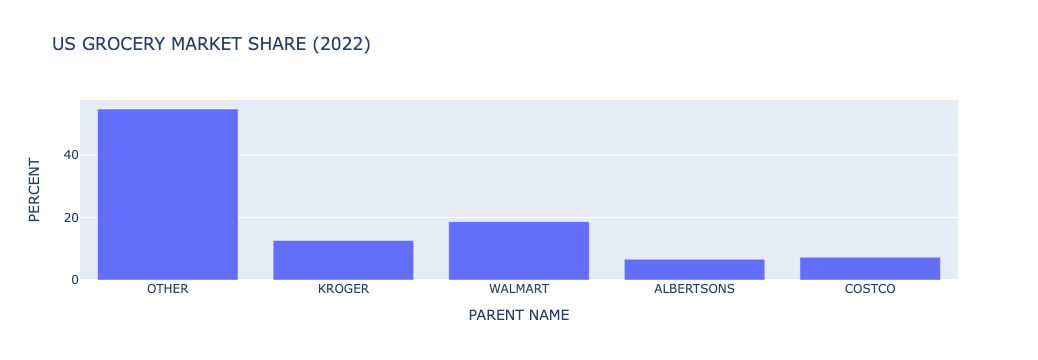

In [88]:
### Market Share = (Bussines Rev/Total Industry Rev) x 100
### Decided to Drop AHOLD DELHAIZE since it is insignifcant in terms of its value of 0.06 billion
market_share = supermarkets_2022.iloc[:,[-2,-1]]
market_share = market_share.drop_duplicates().reset_index().drop(columns="index").rename(columns={"PARENT TRUE SALES (BILLIONS)":"SALES (BILLIONS)"})
market_share["PERCENT"] = (market_share["SALES (BILLIONS)"] / market_share["SALES (BILLIONS)"].sum()) * 100
market_share.drop([4],inplace=True) 

fig = px.bar(market_share, x='PARENT NAME', y='PERCENT',title="US GROCERY MARKET SHARE (2022)")
fig.show()

In [89]:
market_share

,PARENT NAME,SALES (BILLIONS),PERCENT
0,OTHER,641.535248,54.734327
1,KROGER,148.300000,12.652618
2,WALMART,218.944000,18.679804
3,ALBERTSONS,77.649700,6.624896
5,COSTCO,85.600000,7.303197
